In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys,os
import numpy as np
import matplotlib.pyplot as plt

##############
#For plotting
from matplotlib import rc
from matplotlib import rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True
#rcParams['text.fontsize'] = 16

import george
from george import kernels
from george.kernels import ExpSquaredKernel

from scipy import optimize as op

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example Persues GP Fit

This is a first attempt at doing profile likelihood with a GP background model.  This notebook has three parts.  

1.  First, we load in the data and do a fit with the general GP model to get a sense for the underlying model.  Then, we will make Monte Carlo data from that underlying model.
2.  We will look at profile likelihood of the Monte Carlo data with a simple background model that consists of a double-exponential GP model with a large scale length.  This isn't going to work great.
3.  Will attempt to add in more structure to the sidebands by adding in a forest of lines on both sides of the putative signal window.

## First, we load in the data

1.  counts_data: the data counts
2.  errors: the guassian errors
3.  Epns: the energies in keV
4. z_pers: the redshift of the cluster
5.  E_3p5: the energy of the 3.55 keV line after accounting for redshift

In [7]:
count_data=np.load(work_dir+"local/perseus_data_example.npy")
errors=np.load(work_dir+"local/perseus_data_example_errors.npy")
Epns=np.load(work_dir+"local/perseus_data_example_energies.npy")
z_pers = 0.016

E_3p5 = 3.55/(1+z_pers)

## Plot of the data

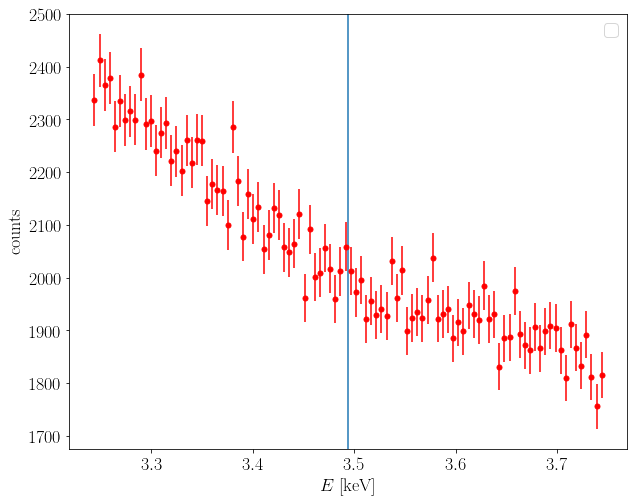

In [13]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Epns, count_data, errors, fmt='r.', markersize=10)
plt.axvline(E_3p5)
plt.ylabel(r'counts',fontsize=18)
plt.xlabel(r'$E$ [keV]',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc=1,fontsize=18)

## Do a fit and make MC

Here we will fit to an `ExpSquaredKernel` with a scale length of `0.05` keV.  We are doing this to get a model to make MC from.

In [20]:
k_back = kernels.ConstantKernel(10)*kernels.ExpSquaredKernel(0.05**2) #kernels.ConstantKernel(4)* #66.0**2 * kernels.ExpSquaredKernel(67.0**2)


gp_back = george.GP(k_back, mean=np.mean(count_data))
gp_back.compute(Epns,yerr= errors)
print "params = ",gp_back.kernel.get_parameter_vector()
print(gp_back.lnlikelihood(count_data))




params =  [10.         -5.99146455]
-537.9679213270621


### Use scipy.optimize.minimize to get best-fit normalization

We maximimize the log likelihood

In [35]:
def nll_back(p):
    # Update the kernel parameters and compute the likelihood.
    gp_back.kernel.set_parameter_vector(p)
    gp_back.compute(Epns,yerr= errors)
    ll = gp_back.lnlikelihood(count_data, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

def nll_back_A(A_vec):
    p = np.array([A_vec[0],np.log(0.05**2)])
    return nll_back(p)

results = op.minimize(nll_back_A, 10.0) #,jac=grad_nll) #, jac=grad_nll) #,bounds=((0,12),(-0.1,+10)))
print results.x

[9.69886776]


### Plot of the data and our best-fit background model

We will use this model for MC

(1200, 2500)

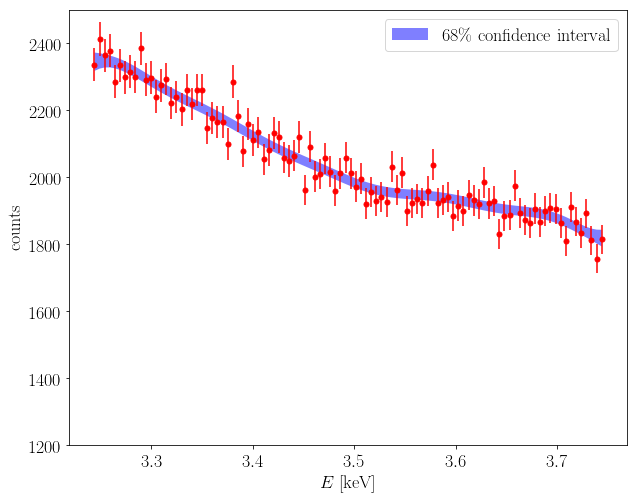

In [43]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
meanGP_back, covGP_back = gp_back.predict(count_data, Epns)
stdGP_back = np.sqrt(np.diag(covGP_back))


# x = Epns
# y = xm0._obs_data
fig = plt.figure(figsize=(10,8))
#plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.errorbar(Epns, count_data, errors, fmt='r.', markersize=10) #, label=u'Observations')
plt.fill(np.concatenate([Epns, Epns[::-1]]),
        np.concatenate([meanGP_back -  1.0 * stdGP_back,
                       (meanGP_back +  1.0 * stdGP_back)[::-1]]),
        alpha=.5, fc='b', ec='None', label=r'68\% confidence interval')
plt.ylabel(r'counts',fontsize=18)
plt.xlabel(r'$E$ [keV]',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(-10, 20)
plt.legend(loc=1,fontsize=18)
plt.ylim(1200,2500)

#plt.savefig(plots_dir +"GP.pdf",bbox_inches="tight")

Below is our function to make Monte Carlo data

In [38]:
def make_fake_data():
    return np.random.normal(loc=meanGP_back,scale=errors)

### Plot an example fake dataset

(1200, 2500)

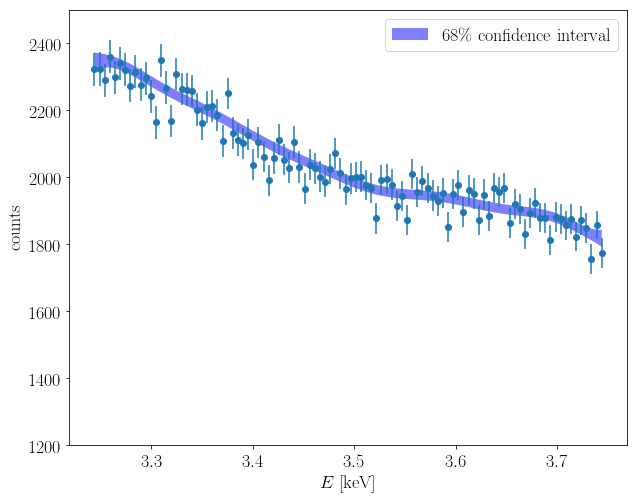

In [45]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Epns,make_fake_data(),errors,fmt="o")
plt.fill(np.concatenate([Epns, Epns[::-1]]),
        np.concatenate([meanGP_back -  1.0 * stdGP_back,
                       (meanGP_back +  1.0 * stdGP_back)[::-1]]),
        alpha=.5, fc='b', ec='None', label=r'68\% confidence interval')

plt.ylabel(r'counts',fontsize=18)
plt.xlabel(r'$E$ [keV]',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(-10, 20)
plt.legend(loc=1,fontsize=18)
plt.ylim(1200,2500)


# First do simple profile likelihood class
Here we only allow for a single smooth background model

In [46]:
# This is going to be our signal model
def gauss_mod(x,xc,A,lam=0.05):
    return A*np.exp(-(x-xc)**2/2./lam**2)*np.sqrt(2/np.pi/lam**2)

In [103]:
lam_long = 1.0
class simple_profile_likelihood:
    def __init__(self,data,lam_long=1.0):
        self._data = data
        self._data_orig = data
        self._lam_long = lam_long
        self._init_gp()
        
        
    def _init_gp(self):
        k_long = kernels.ConstantKernel(10)*kernels.ExpSquaredKernel(self._lam_long**2)
        self._gp = george.GP(k_long, mean=np.mean(self._data))
        self._gp.compute(Epns,yerr= errors)
        
        
    def _nll(self,A_vec):
        p = np.array([A_vec[0],np.log(lam_long**2)])
        # Update the kernel parameters and compute the likelihood.
        self._gp.kernel.set_parameter_vector(p)
        self._gp.compute(Epns,yerr= errors)
        ll = self._gp.lnlikelihood(self._data, quiet=True)
        # The scipy optimizer doesn't play well with infinities.
        return -ll if np.isfinite(ll) else 1e25
    
    def compute_LL(self,A_sig):
        sig = gauss_mod(Epns,E_3p5,A_sig)
        data = self._data_orig - sig
        self._data = data
        self._init_gp()
        
        results = op.minimize(self._nll, 10.0) #,jac=grad_nll) #, jac=grad_nll) #,bounds=((0,12),(-0.1,+10))
        LL = self._gp.lnlikelihood(self._data)
        
        return LL
    
    def get_best_fit(self,A_sig):
        self._LL = self.compute_LL(A_sig)
        meanGP, covGP = self._gp.predict(self._data, Epns)
        stdGP = np.sqrt(np.diag(covGP))

        sig = gauss_mod(Epns,E_3p5,A_sig)
        return meanGP + sig, stdGP,sig
    
    def compute_chi2(self,A_sig):
        back,_,sig = self.get_best_fit(A_sig)
        chi2 = np.sum( (back-sig-self._data)**2/errors**2)
        return chi2
        
        
        
        

In [104]:
fake_data = make_fake_data()
sp = simple_profile_likelihood(fake_data)

In [107]:
mean_null,_,_ = sp.get_best_fit(0.0)
mean_sig,_,sig = sp.get_best_fit(10.0)

(100, 2500)

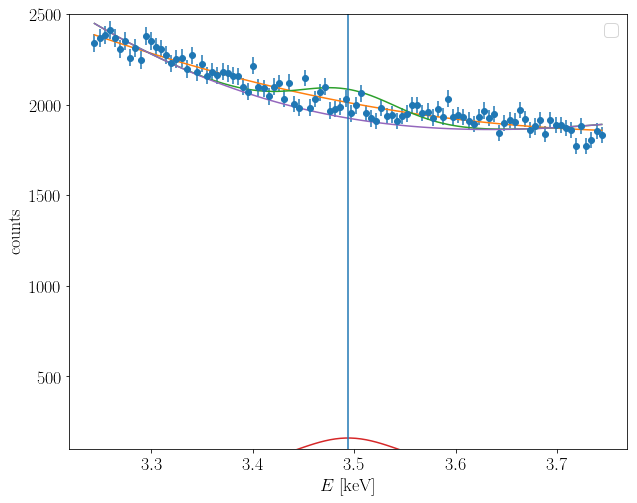

In [108]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Epns,fake_data,errors,fmt="o")
plt.plot(Epns,mean_null)
plt.plot(Epns,mean_sig)
plt.plot(Epns,sig)
plt.plot(Epns,mean_sig-sig)
plt.axvline(E_3p5)


plt.ylabel(r'counts',fontsize=18)
plt.xlabel(r'$E$ [keV]',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(-10, 20)
plt.legend(loc=1,fontsize=18)
plt.ylim(100,2500)


In [109]:
A_array = np.linspace(-10,10,20)
LL_array = np.zeros(20)
chi2_array = np.zeros(20)
for i in range(20):
    chi2_array[i] = sp.compute_chi2(A_array[i])
    LL_array[i] = sp._LL


(0, 30)

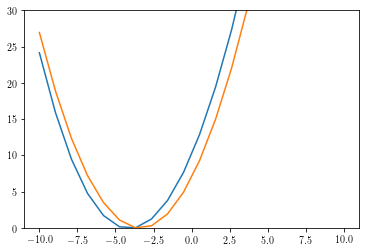

In [110]:
plt.plot(A_array,-2*(LL_array-np.max(LL_array)))
plt.plot(A_array,chi2_array - np.min(chi2_array))
plt.ylim(0,30)

# Now do more complicated profile likelihood class

In [126]:
lam_long = 1.0
lam_short = 0.05
class profile_likelihood:
    def __init__(self,data,lam_long=1.0,lam_short = 0.05,dE_sig = 0.2,N_lines = 2):
        self._data = data
        self._data_orig = data
        self._lam_long = lam_long
        self._lam_short = lam_short
        
        
        self._dE_sig = dE_sig #0.2 # keV
        self._N_lines = N_lines
        
        self._init_lines()
        
        self._init_gp()
        
    def _init_lines(self):
        E_low = np.linspace(np.min(Epns),E_3p5-self._dE_sig/2.,self._N_lines)
        E_high = np.linspace(E_3p5+self._dE_sig/2.,np.max(Epns),self._N_lines)
        self._E_lines = np.append(E_low,E_high)
        
        
    def _init_gp(self):
        E_lines = self._E_lines
        lam_short = self._lam_short
        k_lines_tot = kernels.ConstantKernel(10)*kernels.LocalGaussianKernel(location=E_lines[0],log_width=np.log(lam_short**2))
        for i in range(1,len(E_lines)):
            k_lines_tot += kernels.ConstantKernel(10)*kernels.LocalGaussianKernel(location=E_lines[i],log_width=np.log(lam_short**2))

        k_long = kernels.ConstantKernel(10)*kernels.ExpSquaredKernel(self._lam_long**2)
        kernel = k_long + k_lines_tot
        self._gp = george.GP(kernel, mean=np.mean(self._data))
        self._gp.compute(Epns,yerr= errors)
        
        
    def _nll(self,A_vec):
        E_lines = self._E_lines        
        p = np.zeros(len(E_lines)*3+2)
        p[0] = A_vec[0]
        p[1] = np.log(lam_long**2)
        #p_vec[0:1] = np.array([vec[0],0.0])
        for i in range(len(E_lines)):
            p[2+3*i] = A_vec[i+1] #,E_lines[i],np.log(0.05)])
            p[2+3*i+1] = E_lines[i]
            p[2+3*i+2] = np.log(self._lam_short**2)
        # Update the kernel parameters and compute the likelihood.
        self._gp.kernel.set_parameter_vector(p)
        self._gp.compute(Epns,yerr= errors)
        ll = self._gp.lnlikelihood(self._data, quiet=True)
        # The scipy optimizer doesn't play well with infinities.
        return -ll if np.isfinite(ll) else 1e25
    
    def compute_LL(self,A_sig):
        sig = gauss_mod(Epns,E_3p5,A_sig)
        data = self._data_orig - sig
        self._data = data
        self._init_gp()
        
        p0 = np.zeros(1+len(self._E_lines))
        results = op.minimize(self._nll, p0) #,jac=grad_nll) #, jac=grad_nll) #,bounds=((0,12),(-0.1,+10))
        LL = self._gp.lnlikelihood(self._data)
        
        return LL
    
    def get_best_fit(self,A_sig):
        self._LL = self.compute_LL(A_sig)
        meanGP, covGP = self._gp.predict(self._data, Epns)
        stdGP = np.sqrt(np.diag(covGP))

        sig = gauss_mod(Epns,E_3p5,A_sig)
        return meanGP + sig, stdGP,sig
    
    def compute_chi2(self,A_sig):
        back,_,_ = self.get_best_fit(A_sig)
        chi2 = np.sum( (back-self._data)**2/errors**2)
        return chi2
        
        
        
        

In [127]:
fake_data = make_fake_data()
sp = profile_likelihood(fake_data)

In [135]:
#mean_null,_,_ = sp.get_best_fit(0.0)
mean_sig,_,sig = sp.get_best_fit(8.0)

(10, 2500)

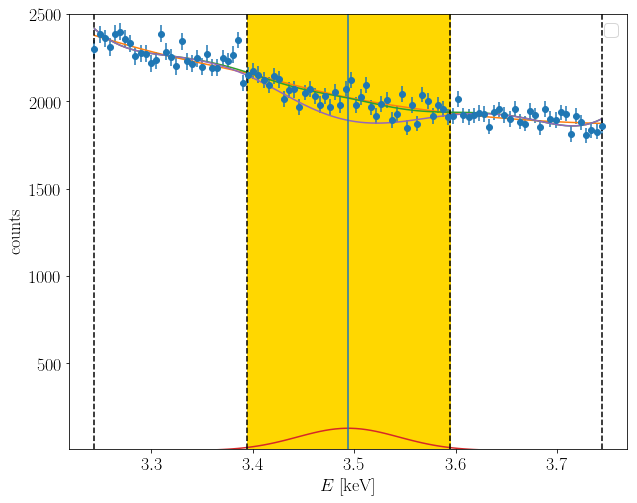

In [140]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Epns,fake_data,errors,fmt="o")
plt.plot(Epns,mean_null)
plt.plot(Epns,mean_sig)
plt.plot(Epns,sig)
plt.plot(Epns,mean_sig-sig)
plt.axvline(E_3p5)
for i in range(len(sp._E_lines)):
    plt.axvline(sp._E_lines[i],color="black",linestyle="dashed")
    
plt.axvspan(E_3p5-sp._dE_sig/2.,E_3p5+sp._dE_sig/2.,color="gold")


plt.ylabel(r'counts',fontsize=18)
plt.xlabel(r'$E$ [keV]',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(-10, 20)
plt.legend(loc=1,fontsize=18)
plt.ylim(10,2500)


In [142]:
A_array = np.linspace(-8,8,20)
LL_array = np.zeros(20)
chi2_array = np.zeros(20)
for i in range(20):
    print "On i = ",i
    chi2_array[i] = sp.compute_chi2(A_array[i])
    LL_array[i] = sp._LL


On i =  0
On i =  1
On i =  2
On i =  3
On i =  4
On i =  5
On i =  6
On i =  7
On i =  8


LinAlgError: 6-th leading minor of the array is not positive definite

In [ ]:
plt.plot(A_array,-2*(LL_array-np.max(LL_array)))
plt.plot(A_array,chi2_array - np.min(chi2_array))
plt.ylim(0,30)